# Testing and running simulatons

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
from collections import Counter, defaultdict
from scipy import integrate
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm
import tqdm
import matplotlib.ticker as ticker
from sklearn.metrics import r2_score
import scipy
from sklearn.linear_model import LinearRegression
import time

from simulation.SEIR_model import SEIRModel
from simulation.model_output import SEIRModelOutput

In [2]:
data = pd.read_csv('./data/wave_2014-2015_spb.csv', sep='\t', index_col=0)
weekly_incidence_data = data['total_cases'].to_numpy()[18:-6]

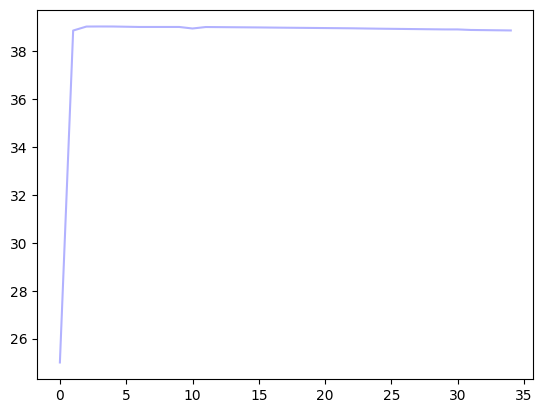

In [60]:
model = SEIRModel(population=5*1e6)
R_0 = 1

t_incubation = 2 # in days
t_infective = 7 # in days

alpha = 1/t_incubation
gamma = 1/t_infective
beta = gamma*R_0
init_inf_frac = 0.00001
init_rec_frac = 0
tmax = 245 # days

res = model.simulate(alpha=alpha, beta=beta, gamma=gamma, 
                        init_inf_frac=init_inf_frac, 
                        init_rec_frac=init_rec_frac, tmax=tmax)

plt.plot(res.weekly_incidence, color='blue', alpha=0.3)

In [61]:
t_incubation_arr = np.arange(t_incubation-2, t_incubation+4)
t_infective_arr = np.arange(t_infective-4, t_infective+4)
R_0_arr = np.linspace(1, 5, 10)
init_rec_frac_arr = np.linspace(1e-6, 0.2, 10)

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_6784\2309933702.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = 1/t_incubation
100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


Text(0.5, 1.0, '$R_0 \\in [$1.0, 5.0$]$, $\\tau (inc.) \\in [$0, 5$]$,$\\tau (inf.) \\in [$3, 10$]$, immune fraction $\\in [$1e-06, 0.2$]$')

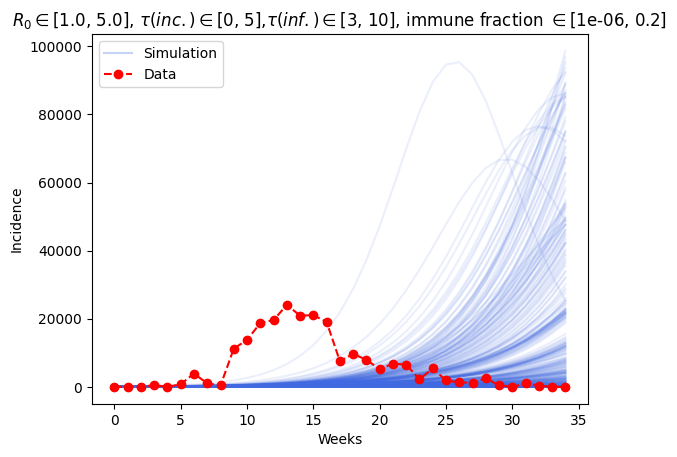

In [65]:
MAX_INCIDENCE_LIMITATION = 1e5

for t_incubation in tqdm.tqdm(t_incubation_arr):
    for t_infective in t_infective_arr:
        for R_0 in R_0_arr:
            for init_rec_frac in init_rec_frac_arr:
                alpha = 1/t_incubation
                gamma = 1/t_infective
                beta = gamma*R_0
                res = model.simulate(alpha=alpha, beta=beta, gamma=gamma, 
                                     init_inf_frac=init_inf_frac, 
                                     init_rec_frac=init_rec_frac, tmax=tmax)
                if (res.weekly_incidence < MAX_INCIDENCE_LIMITATION).all():
                    plt.plot(res.weekly_incidence, color='RoyalBlue', alpha=0.1)
res = model.simulate(alpha=alpha, beta=beta, gamma=gamma, 
                                     init_inf_frac=0, 
                                     init_rec_frac=init_rec_frac, tmax=tmax)
plt.plot(res.weekly_incidence, color='RoyalBlue', alpha=0.3, label='Simulation')
plt.plot(weekly_incidence_data, '--o', color='red', label='Data')    
plt.xlabel('Weeks')
plt.ylabel('Incidence')
plt.legend()
plt.title(r'$R_0 \in [${}, {}$]$, $\tau (inc.) \in [${}, {}$]$,$\tau (inf.) \in [${}, {}$]$, immune fraction $\in [${}, {}$]$'.format(R_0_arr[0], R_0_arr[-1],
                                               t_incubation_arr[0], t_incubation_arr[-1],
                                               t_infective_arr[0], t_infective_arr[-1],
                                               init_rec_frac_arr[0], init_rec_frac_arr[-1]))

In [159]:
def AnnealingModel(x):
    beta, init_rec_frac = x
    sim = model.simulate(alpha=alpha, beta=beta, gamma=gamma, 
                         init_inf_frac=init_inf_frac, init_rec_frac=init_rec_frac, 
                         tmax=tmax)
    weekly_incidence_sim = sim.weekly_incidence
    return -r2_score(weekly_incidence_sim, weekly_incidence_data)

lw = [1e-10, 1e-6]
up = [1e-8, 0.1]

ret = scipy.optimize.dual_annealing(AnnealingModel, bounds=list(zip(lw, up)))

In [164]:
beta_best, init_rec_frac_best = ret.x[0], ret.x[1]
print(beta_best, init_inf_frac)
print('R^2 score:', ret.fun)

6.352802096407088e-09 1e-05
R^2 score: 0.3250629360675539


In [183]:
model = SEIRModel(population=5*10e6)
alpha = 0.05
beta = 4.5e-9
gamma = 1/7
init_inf_frac = 1e-5
init_rec_frac = 1e-5
tmax = 245 # days
res = model.simulate(alpha=alpha, beta=beta, gamma=gamma, 
                     init_inf_frac=init_inf_frac, 
                     init_rec_frac=init_rec_frac, tmax=tmax)

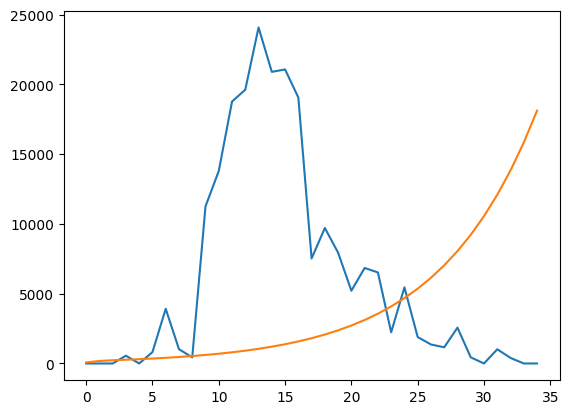

In [184]:
plt.plot(weekly_incidence_data)
plt.plot(res.weekly_incidence)